# Proyek Klasifikasi Gambar: animals10
- **Nama:** Putu Widyantara Artanta Wibawa
- **Email:** putuwaw973@gmail.com
- **ID Dicoding:** putu_waw

## Import Library
- Install split-folders for splitting dataset folder into train and testing
- Tensorflowjs for converting SavedModel to TFJS
- Udocker for run TF Serving with small configuration

In [1]:
!pip install -q split-folders tensorflowjs udocker

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.83.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
apache-beam 2.44.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.


In [2]:
import tensorflow as tf
import numpy as np
import keras

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split

import os
import random
import subprocess
import shutil
import json

import requests
import splitfolders
from PIL import Image

In [3]:
tf.__version__

'2.11.0'

# Data Preparation

## Data Loading

In [4]:
# copy dataset from kaggle input to kaggle working
# because kaggle input can't be modified
dataset = "/kaggle/input/animals10/raw-img"

src = dataset
dst = "/kaggle/working/animal10"

shutil.copytree(src, dst)

'/kaggle/working/animal10'

In [5]:
DATASET_PATH = dst

In [6]:
# dataset folder is not in english
translate = {
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
    "scoiattolo": "squirrel",
    "ragno": "spider",
    # from eng
    "dog": "cane",
    "cavallo": "horse",
    "elephant": "elefante",
    "butterfly": "farfalla",
    "chicken": "gallina",
    "cat": "gatto",
    "cow": "mucca",
    "spider": "ragno",
    "squirrel": "scoiattolo",
}

In [7]:
for folder_name in os.listdir(DATASET_PATH):
    os.rename(
        f"{DATASET_PATH}/{folder_name}", f"{DATASET_PATH}/{translate.get(folder_name)}"
    )

In [8]:
# make sure that image have different resolution
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for idx, size in enumerate(unique_sizes):
            print(f"- {size}")
            # limit output so it not truncated by colab
            # 10 different size is enought to show that
            # the images already have diff resolution
            if idx > 10:
                break
        print("---------------")

    print(f"\nTotal: {total_images}")


print_images_resolution(DATASET_PATH)

squirrel: 1862
- (300, 161)
- (300, 238)
- (264, 300)
- (278, 300)
- (153, 179)
- (300, 249)
- (202, 300)
- (288, 300)
- (287, 300)
- (206, 300)
- (285, 300)
- (228, 300)
---------------
cow: 1866
- (264, 300)
- (202, 300)
- (206, 300)
- (300, 202)
- (300, 279)
- (252, 300)
- (235, 300)
- (300, 224)
- (199, 132)
- (300, 254)
- (262, 300)
- (300, 119)
---------------
cat: 1668
- (530, 640)
- (264, 300)
- (640, 473)
- (300, 172)
- (202, 300)
- (206, 300)
- (640, 511)
- (300, 202)
- (300, 279)
- (252, 300)
- (235, 300)
- (640, 602)
---------------
dog: 4863
- (530, 640)
- (264, 300)
- (640, 473)
- (300, 172)
- (202, 300)
- (206, 300)
- (640, 511)
- (300, 202)
- (300, 279)
- (252, 300)
- (235, 300)
- (640, 602)
---------------
elephant: 1446
- (530, 640)
- (264, 300)
- (640, 473)
- (640, 526)
- (300, 172)
- (202, 300)
- (206, 300)
- (285, 194)
- (640, 511)
- (300, 202)
- (300, 279)
- (252, 300)
---------------
sheep: 1820
- (530, 640)
- (382, 640)
- (264, 300)
- (640, 473)
- (640, 526)
- (

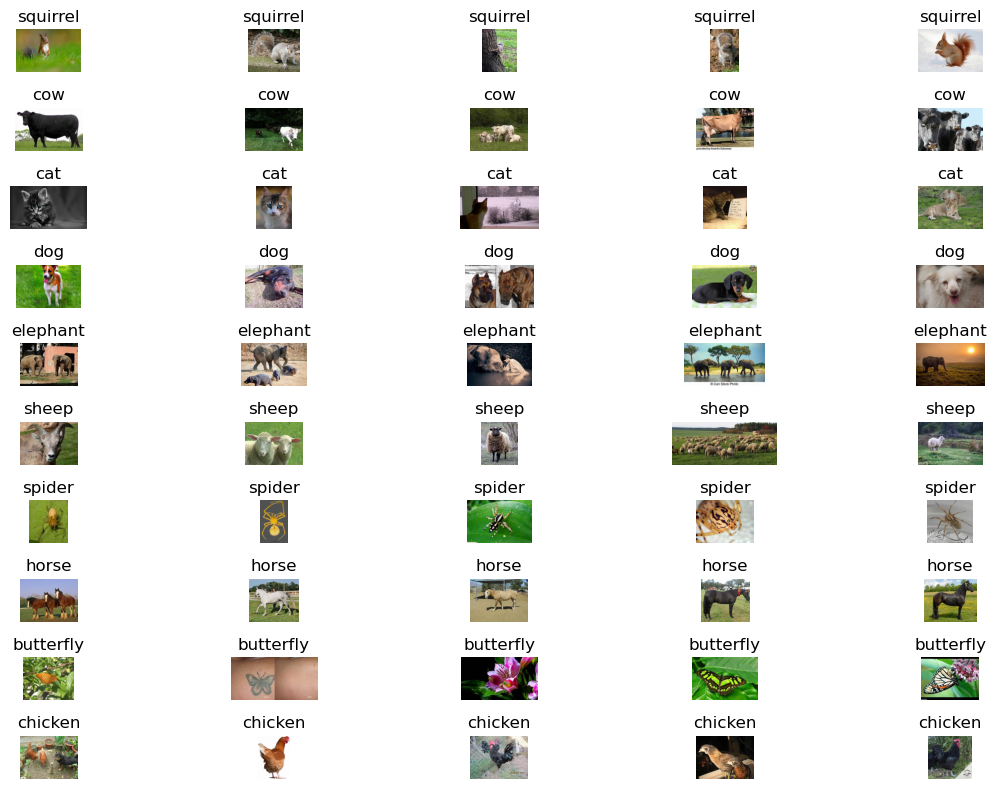

In [9]:
categories = os.listdir(DATASET_PATH)
fig, ax = plt.subplots(len(categories), 5, figsize=(12, 8))
for i, category in enumerate(categories):
    category_dir = os.path.join(DATASET_PATH, category)
    image_files = os.listdir(category_dir)

    for j in range(5):
        rdm = random.randint(0, len(image_files))
        img_path = os.path.join(category_dir, image_files[rdm])
        img = mpimg.imread(img_path)
        ax[i, j].imshow(img)
        ax[i, j].set_title(category)
        ax[i, j].axis("off")

plt.tight_layout()
plt.show()

## Data Preprocessing

In [10]:
# split 80% for training, 20% for testing
splitfolders.ratio(DATASET_PATH, output=DATASET_PATH, seed=42, ratio=(.8, .2))

Copying files: 26179 files [00:04, 5814.31 files/s]


In [11]:
# remove old folder, keep train and val only
for category in categories:
    shutil.rmtree(f"{DATASET_PATH}/{category}")

In [12]:
os.listdir(DATASET_PATH)

['val', 'train']

In [13]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [14]:
INPUT_SHAPE = (224, 224, 3)
train_dir = f"{DATASET_PATH}/train"
test_dir = f"{DATASET_PATH}/val"

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=INPUT_SHAPE[:2],
    class_mode="categorical",
    seed=42,
    batch_size=32,
)

test_generator = test_datagen.flow_from_directory(
    test_dir, 
    target_size=INPUT_SHAPE[:2], 
    seed=42, 
    batch_size=32, 
)

Found 20938 images belonging to 10 classes.
Found 5241 images belonging to 10 classes.


# Modeling
- Using transfer learning from EfficientNet with additional Sequential, Conv2D, and Pooling

In [15]:
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB7(
    input_shape=(224, 224, 3), include_top=False, weights="imagenet", pooling="max"
)

pretrained_model.trainable = False

258076736/258076736 [==============================] - 7s 0us/step


In [16]:
# custom callbacks
class EarlyStoppingByAccuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        acc = logs.get("accuracy", None)
        val_acc = logs.get("val_accuracy", None)
        if acc is not None and val_acc is not None:
            if acc >= 0.96 and val_acc >= 0.96:
                print(f"\nStopping training: accuracy and validation exceeded 0.96")
                self.model.stop_training = True

In [17]:
# callbacks
early_stopping_by_accuracy = EarlyStoppingByAccuracy()
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.1, patience=3, min_lr=1e-8
)

In [18]:
layer_index = -5
new_output = pretrained_model.layers[layer_index].output
subset_model = tf.keras.Model(inputs=pretrained_model.input, outputs=new_output)

In [19]:
# sequential preprocessing
augment = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.Resizing(224, 224),
        tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255),
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
        tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
    ]
)

In [20]:
inputs = pretrained_model.input
# sequential
x = augment(inputs)
x = tf.keras.layers.Conv2D(
    name="top_conv",
    trainable=False,
    dtype="float32",
    filters=2560,
    kernel_size=(1, 1),
    strides=(1, 1),
    padding="same",
    data_format="channels_last",
    dilation_rate=(1, 1),
    groups=1,
    activation="linear",
    use_bias=False,
    kernel_initializer={
        "class_name": "VarianceScaling",
        "config": {
            "scale": 2.0,
            "mode": "fan_out",
            "distribution": "truncated_normal",
            "seed": None,
        },
    },
    bias_initializer={"class_name": "Zeros", "config": {}},
)(subset_model.output)
x = tf.keras.layers.BatchNormalization(trainable=False, name="top_bn")(x)
x = tf.keras.layers.Activation(
    "swish", trainable=False, dtype="float32", name="top_activation"
)(x)
x = tf.keras.layers.GlobalMaxPool2D(
    name="max_pool",
    trainable=False,
    dtype="float32",
    data_format="channels_last",
    keepdims=False,
)(x)
# fully connected layer
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(10, activation="softmax")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [21]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [22]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0]']    

In [23]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=100,
    callbacks=[
        early_stopping_by_accuracy,
        early_stopping,
        reduce_lr,
    ],
)

Epoch 1/100


2024-10-06 11:54:25.064158: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


655/655 [==============================] - 215s 286ms/step - loss: 2.3330 - accuracy: 0.3220 - val_loss: 0.7061 - val_accuracy: 0.8208 - lr: 1.0000e-05
Epoch 2/100
655/655 [==============================] - 179s 273ms/step - loss: 1.1692 - accuracy: 0.6297 - val_loss: 0.3894 - val_accuracy: 0.9136 - lr: 1.0000e-05
Epoch 3/100
655/655 [==============================] - 179s 273ms/step - loss: 0.7850 - accuracy: 0.7609 - val_loss: 0.2839 - val_accuracy: 0.9336 - lr: 1.0000e-05
Epoch 4/100
655/655 [==============================] - 179s 273ms/step - loss: 0.6100 - accuracy: 0.8164 - val_loss: 0.2350 - val_accuracy: 0.9397 - lr: 1.0000e-05
Epoch 5/100
655/655 [==============================] - 179s 273ms/step - loss: 0.5008 - accuracy: 0.8531 - val_loss: 0.2083 - val_accuracy: 0.9460 - lr: 1.0000e-05
Epoch 6/100
655/655 [==============================] - 179s 273ms/step - loss: 0.4299 - accuracy: 0.8769 - val_loss: 0.1839 - val_accuracy: 0.9504 - lr: 1.0000e-05
Epoch 7/100
655/655 [=======

# Evaluation & Visualization

In [24]:
result = model.evaluate(test_generator)
print(f"Accuracy: {result[1]}")

164/164 [==============================] - 39s 234ms/step - loss: 0.1125 - accuracy: 0.9704
Accuracy: 0.9704254865646362


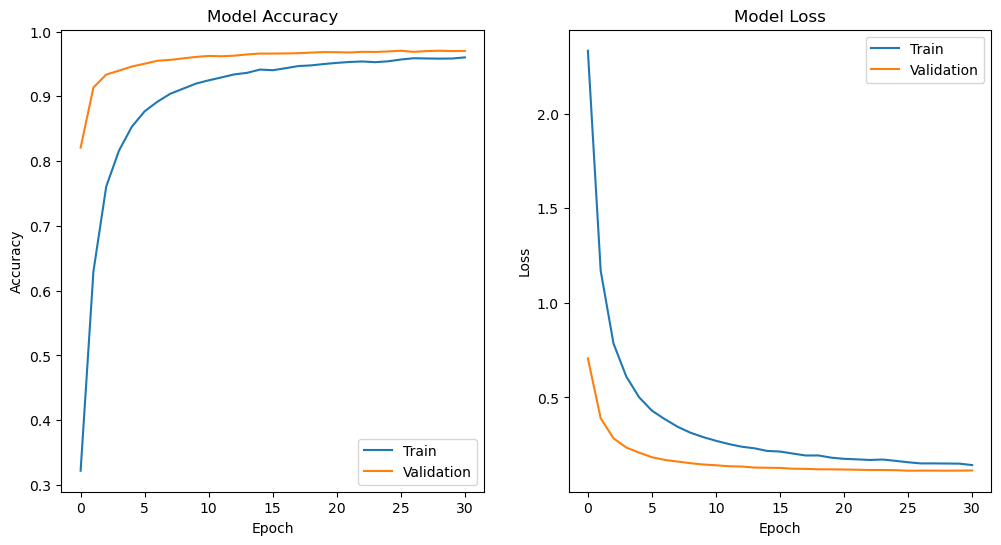

In [25]:
# acc
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])

# lost
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])

# Model Convertion

In [26]:
# saved model
tf.saved_model.save(model, "/kaggle/working/clf_model")

In [27]:
# tf lite
converter = tf.lite.TFLiteConverter.from_saved_model("/kaggle/working/clf_model")
tflite_model = converter.convert()

with open("/kaggle/working/model.tflite", "wb") as f:
    f.write(tflite_model)

In [28]:
# tf js
# prevent to use gpu that cause memory error
os.environ["CUDA_VISIBLE_DEVICES"] = ""
subprocess.run(
    [
        "tensorflowjs_converter",
        "--input_format", "tf_saved_model",
        "--output_format", "tfjs_graph_model",
        "/kaggle/working/clf_model",
        "/kaggle/working/tfjs",
    ]
)

2024-10-06 13:31:32.803552: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Writing weight file /kaggle/working/tfjs/model.json...


CompletedProcess(args=['tensorflowjs_converter', '--input_format', 'tf_saved_model', '--output_format', 'tfjs_graph_model', '/kaggle/working/clf_model', '/kaggle/working/tfjs'], returncode=0)

# Inference (TF Serving)

In [29]:
def get_inference_image(img_path) -> list:
    img = tf.keras.preprocessing.image.load_img(
        img_path, target_size=(224, 224)
    )  # resize
    img_array = tf.keras.preprocessing.image.img_to_array(img)  # add color mode
    img_array = np.expand_dims(img_array, axis=0)  # add batch dim
    return img_array.tolist()

In [30]:
def get_class_name(idx) -> str:
    class_indices = train_generator.class_indices
    labels = dict((v, k) for k, v in class_indices.items())
    return labels[idx]

In [31]:
# run tf serving using udocker
subprocess.Popen(
    [
        "udocker","--allow-root",
        "run","-t","--rm","-p","8501:8501",
        "-v","/kaggle/working/clf_model:/models/clf/1",
        "-e","MODEL_NAME=clf",
        "-e","TF_CPP_VMODULE=http_server=1", # verbose when predict
        "tensorflow/serving",
    ]
)

2024-10-06 13:36:41.953542: I tensorflow_serving/model_servers/server.cc:77] Building single TensorFlow model file config:  model_name: clf model_base_path: /models/clf
2024-10-06 13:36:41.954493: I tensorflow_serving/model_servers/server_core.cc:474] Adding/updating models.
2024-10-06 13:36:41.954596: I tensorflow_serving/model_servers/server_core.cc:603]  (Re-)adding model: clf
2024-10-06 13:36:42.178444: I tensorflow_serving/core/basic_manager.cc:740] Successfully reserved resources to load servable {name: clf version: 1}
2024-10-06 13:36:42.178628: I tensorflow_serving/core/loader_harness.cc:68] Approving load for servable version {name: clf version: 1}
2024-10-06 13:36:42.179131: I tensorflow_serving/core/loader_harness.cc:76] Loading servable version {name: clf version: 1}
2024-10-06 13:36:42.179739: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /models/clf/1
2024-10-06 13:36:42.515712: I external/org_tensorflow/tensorflow/cc/saved_mod

In [32]:
# get random image
random_category = random.choice(os.listdir(f"{DATASET_PATH}/val"))
random_file = random.choice(os.listdir(f"{DATASET_PATH}/val/{random_category}"))
img_path = f"{DATASET_PATH}/val/{random_category}/{random_file}"

In [33]:
inference_img = get_inference_image(img_path)
data = json.dumps({"signature_name": "serving_default", "instances": inference_img})

In [34]:
headers = {"content-type": "application/json"}
json_response = requests.post(
    "http://localhost:8501/v1/models/clf:predict", data=data, headers=headers
)
predictions = json.loads(json_response.text)

2024-10-06 13:54:09.870136: I tensorflow_serving/model_servers/http_server.cc:166] Processing HTTP request: POST /v1/models/clf:predict body: 1105322 bytes.


In [35]:
predictions

{'predictions': [[5.7246576e-05,
   2.37539589e-05,
   6.73157774e-06,
   7.70932456e-06,
   4.00234194e-06,
   5.8780457e-05,
   0.000181758078,
   1.29830314e-05,
   1.79374911e-05,
   0.999629]]}

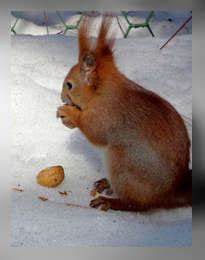

In [36]:
Image.open(img_path)

In [37]:
result = get_class_name(np.argmax(predictions["predictions"]))
print(f"Expected: {random_category}")
print(f"Prediction: {result}")

Expected: squirrel
Prediction: squirrel


In [38]:
# create label.txt
keys = train_generator.class_indices.keys()
with open('label.txt', 'w') as file:
    for key in keys:
        file.write(key + '\n')

In [39]:
!rm -rf /kaggle/working/animal10

In [40]:
# zip all files
!zip -q -r submission.zip /kaggle/working